# 1.주제: 주거 및 공용 공간 내 이상행동 영상 데이터를 이용한 실내 이상행동 탐지

## 데이터 수집: AI hub 주거 및 공용 공간 내 이상행동 영상 데이터

### 데이터 전처리 (필요한 데이터만 추출)

In [2]:
import json

# 원본 JSON 파일 경로
input_path = r'dataset\1.Training\라벨링데이터\TL16\폭행_강도-위협물체\방망이로 위협\C031_A23_SY21_P01_S06_10DAS.json'
# 새로 저장할 JSON 파일 경로
output_path = 'reformatted_output.json'

with open(input_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 보기 쉬운 구조로 재구성 (예시: 들여쓰기, 정렬)
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"새로운 JSON 파일로 저장 완료: {output_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\1.Training\\라벨링데이터\\TL16\\폭행_강도-위협물체\\방망이로 위협\\C031_A23_SY21_P01_S06_10DAS.json'

In [ ]:
with open('reformatted_output.json') as r:
    data = json.load(r)

In [ ]:
data.keys()

dict_keys(['filename', 'date', 'file_format', 'file_size', 'device_info', 'shooting', 'place', 'copyright', 'length', 'length_type', 'FPS', 'width', 'height', 'resolution', 'bit', 'depth', 'definition', 'LDC', 'angle', 'CCTV_distribution', 'Day_night', 'Scenario'])

In [ ]:
data["metadata"]["filename"]

'C031_A23_SY21_P01_S06_10DAS.mp4'

#### 위협행동으로 인식되는 비디오 프레임 추출

In [ ]:
data_action = data["file"][0]["videos"]["block_information"][2]
data_action_start_frame = data["file"][0]["videos"]["block_information"][2]["start_frame_index"]
data_action_end_frame = data["file"][0]["videos"]["block_information"][2]["end_frame_index"]
block_detail = data["file"][0]["videos"]["block_information"][2]["block_detail"]
data_action
block_detail

'A23'

#### 해당 키포인트 추출
필요 프레임에서 5등분하여 추출

In [ ]:
import numpy as np

start_idx = int(data_action_start_frame)
end_idx = int(data_action_end_frame)

frame_indices = np.linspace(start_idx, end_idx, 5, dtype=int)

frames = data["file"][0]["frames"]
data_keypoints_5 = [frames[i] for i in frame_indices]
data_keypoints_5
for idx in range(5):
    ss = data_keypoints_5[idx]["persons"][0]["keypoints"]
    dd = data_keypoints_5[idx]["frame_index"]
    print(dd, ss)

2837 ['1348.604651,356.942703', '1389.114779,395.192725', '1350.855214,380.567725', '1345.791448,432.880225', '1339.039760,470.567725', '1418.934734,407.005225', '1355.356339,465.505225', '1343.540885,395.755225', '1392.490623,504.317725', '1363.795949,501.505225', '1376.736684,557.192725', '1392.490623,593.192725', '1425.123781,506.005225', '1439.189797,579.692725', '1449.317329,626.942725']
3027 ['1482.108027,274.305828', '1486.853882,294.943329', '1442.689087,286.048431', '1401.087772,306.368328', '1376.331583,316.493328', '1533.907837,315.349792', '1516.128296,386.113647', '1463.540885,374.993350', '1475.093018,415.542206', '1448.472046,412.643066', '1445.504639,512.589722', '1439.785400,594.993530', '1504.561279,418.492249', '1513.389893,503.702972', '1516.279419,553.707031']
3218 ['1523.721619,221.278442', '1539.854004,244.726219', '1495.624145,227.113083', '1459.883721,257.782413', '1424.000432,257.368013', '1586.762024,252.169029', '1576.648926,319.801895', '1517.725952,313.914

#### 데이터 병합
- filename
- keypoints
- block_detail
- frame_index

#### 방망이 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'origin_Data\1.Training\라벨링데이터\방망이'
output_dir = r'dataset\1.Training\new_labeling_data\방망이'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C031_A23_SY21_P01_S06_10DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S06_10DAS.json 저장 완료
C031_A23_SY21_P01_S07_09DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S07_09DAS.json 저장 완료
C031_A23_SY21_P01_S10_08DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S10_08DAS.json 저장 완료
C031_A23_SY21_P01_S10_08DBS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S10_08DBS.json 저장 완료
C031_A23_SY21_P01_S10_09DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S10_09DAS.json 저장 완료
C031_A23_SY21_P01_S10_10DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S10_10DAS.json 저장 완료
C031_A23_SY21_P01_S10_10DBS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S10_10DBS.json 저장 완료
C031_A23_SY21_P01_S11_08DAS.json → dataset\1.Training\new_labeling_data\방망이\C031_A23_SY21_P01_S11_08DAS.json 저장 완료
C031_A23_SY21_P01_S11_08DBS.json → dataset\1.Training\new_labeling_data\방망이\C031

#### 주먹 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'origin_Data\1.Training\라벨링데이터\주먹'
output_dir = r'dataset\1.Training\new_labeling_data\주먹'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C032_A24_SY21_P01_S01_01DAS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S01_01DAS.json 저장 완료
C032_A24_SY21_P01_S01_01DBS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S01_01DBS.json 저장 완료
C032_A24_SY21_P01_S02_01DAS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S02_01DAS.json 저장 완료
C032_A24_SY21_P01_S02_01DBS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S02_01DBS.json 저장 완료
C032_A24_SY21_P01_S03_01DAS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S03_01DAS.json 저장 완료
C032_A24_SY21_P01_S04_01DAS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S04_01DAS.json 저장 완료
C032_A24_SY21_P01_S04_01DBS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S04_01DBS.json 저장 완료
C032_A24_SY21_P01_S05_01DAS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21_P01_S05_01DAS.json 저장 완료
C032_A24_SY21_P01_S05_01DBS.json → dataset\1.Training\new_labeling_data\주먹\C032_A24_SY21

#### 발 분류

In [ ]:
import json
import numpy as np
import os

input_dir = r'origin_Data\1.Training\라벨링데이터\발'
output_dir = r'dataset\1.Training\new_labeling_data\발'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C032_A26_SY21_P01_S01_01DAS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S01_01DAS.json 저장 완료
C032_A26_SY21_P01_S01_01DBS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S01_01DBS.json 저장 완료
C032_A26_SY21_P01_S01_02DAS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S01_02DAS.json 저장 완료
C032_A26_SY21_P01_S02_01DAS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S02_01DAS.json 저장 완료
C032_A26_SY21_P01_S02_01DBS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S02_01DBS.json 저장 완료
C032_A26_SY21_P01_S02_02DAS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S02_02DAS.json 저장 완료
C032_A26_SY21_P01_S02_02DBS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S02_02DBS.json 저장 완료
C032_A26_SY21_P01_S04_01DAS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S04_01DAS.json 저장 완료
C032_A26_SY21_P01_S04_01DBS.json → dataset\1.Training\new_labeling_data\발\C032_A26_SY21_P01_S04_

#### 칼 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'origin_Data\1.Training\라벨링데이터\칼'
output_dir = r'dataset\1.Training\new_labeling_data\칼'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C031_A22_SY21_P01_S01_01DAS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S01_01DAS.json 저장 완료
C031_A22_SY21_P01_S01_01DBS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S01_01DBS.json 저장 완료
C031_A22_SY21_P01_S01_02DAS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S01_02DAS.json 저장 완료
C031_A22_SY21_P01_S01_02DBS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S01_02DBS.json 저장 완료
C031_A22_SY21_P01_S02_01DAS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S02_01DAS.json 저장 완료
C031_A22_SY21_P01_S02_01DBS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S02_01DBS.json 저장 완료
C031_A22_SY21_P01_S02_02DAS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S02_02DAS.json 저장 완료
C031_A22_SY21_P01_S02_02DBS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S02_02DBS.json 저장 완료
C031_A22_SY21_P01_S04_01DAS.json → dataset\1.Training\new_labeling_data\칼\C031_A22_SY21_P01_S04_

#### 테스트 데이터셋 분할

In [ ]:
import os
import shutil

# 분할할 폴더 경로 지정
input_dir = r'dataset\2.Validation\원천데이터\VS16\폭행_강도-위협물체\방망이로 위협'  # <- mp4 파일들이 있는 폴더로 변경
train_dir = r'dataset\Validation\방망이'  # <- train 저장 폴더
val_dir = r'dataset\3.Test\방망이'      # <- val 저장 폴더

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# mp4 파일 리스트 수집 (정렬해서 순차적으로 분할)
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.mp4')])

split_idx = int(len(file_list) * 0.7)
train_files = file_list[:split_idx]
val_files = file_list[split_idx:]

# 파일 복사
for fname in train_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(train_dir, fname))
for fname in val_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(val_dir, fname))

print(f"Train: {len(train_files)}개, Val: {len(val_files)}개로 분할 완료")

Train: 49개, Val: 21개로 분할 완료


In [ ]:
import os
import shutil

# 분할할 폴더 경로 지정
input_dir = r'dataset\2.Validation\원천데이터\VS17\폭행_강도-위협물체\칼로 위협'  # <- mp4 파일들이 있는 폴더로 변경
train_dir = r'dataset\Validation\칼'  # <- train 저장 폴더
val_dir = r'dataset\3.Test\칼'      # <- val 저장 폴더

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# mp4 파일 리스트 수집 (정렬해서 순차적으로 분할)
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.mp4')])

split_idx = int(len(file_list) * 0.7)
train_files = file_list[:split_idx]
val_files = file_list[split_idx:]

# 파일 복사
for fname in train_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(train_dir, fname))
for fname in val_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(val_dir, fname))

print(f"Train: {len(train_files)}개, Val: {len(val_files)}개로 분할 완료")

Train: 51개, Val: 23개로 분할 완료


In [ ]:
import os
import shutil

# 분할할 폴더 경로 지정
input_dir = r'dataset\2.Validation\원천데이터\VS18\폭행_강도-위협행동\발차기'  # <- mp4 파일들이 있는 폴더로 변경
train_dir = r'dataset\Validation\발'  # <- train 저장 폴더
val_dir = r'dataset\3.Test\발'      # <- val 저장 폴더

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# mp4 파일 리스트 수집 (정렬해서 순차적으로 분할)
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.mp4')])

split_idx = int(len(file_list) * 0.7)
train_files = file_list[:split_idx]
val_files = file_list[split_idx:]

# 파일 복사
for fname in train_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(train_dir, fname))
for fname in val_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(val_dir, fname))

print(f"Train: {len(train_files)}개, Val: {len(val_files)}개로 분할 완료")

Train: 56개, Val: 24개로 분할 완료


In [ ]:
import os
import shutil

# 분할할 폴더 경로 지정
input_dir = r'dataset\2.Validation\원천데이터\VS20\폭행_강도-위협행동\주먹으로 침'  # <- mp4 파일들이 있는 폴더로 변경
train_dir = r'dataset\Validation\주먹'  # <- train 저장 폴더
val_dir = r'dataset\3.Test\주먹'      # <- val 저장 폴더

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# mp4 파일 리스트 수집 (정렬해서 순차적으로 분할)
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.mp4')])

split_idx = int(len(file_list) * 0.7)
train_files = file_list[:split_idx]
val_files = file_list[split_idx:]

# 파일 복사
for fname in train_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(train_dir, fname))
for fname in val_files:
    shutil.copy2(os.path.join(input_dir, fname), os.path.join(val_dir, fname))

print(f"Train: {len(train_files)}개, Val: {len(val_files)}개로 분할 완료")

Train: 50개, Val: 22개로 분할 완료


#### 필요 없는 json파일 삭제

In [ ]:
import os

# val 폴더(mp4)와 json 폴더 경로 지정
val_dir = r'dataset\Test\방망이'      # <- val mp4 폴더
json_dir = r'val_ori_data\방망이'  # <- json 파일 폴더

# val 폴더의 mp4 파일명(확장자 제외)만 수집
val_mp4_names = {os.path.splitext(f)[0] for f in os.listdir(val_dir) if f.endswith('.mp4')}

# json_dir 내에서 mp4와 이름이 같은 json 파일 삭제
for file in os.listdir(json_dir):
    if file.endswith('.json'):
        base = os.path.splitext(file)[0]
        if base in val_mp4_names:
            os.remove(os.path.join(json_dir, file))
            print(f"{file} 삭제 완료")

C031_A23_SY23_P05_S07_10DBS.json 삭제 완료
C031_A23_SY23_P05_S08_08DAS.json 삭제 완료
C031_A23_SY23_P05_S08_08DBS.json 삭제 완료
C031_A23_SY23_P05_S08_09DAS.json 삭제 완료
C031_A23_SY23_P05_S08_09DBS.json 삭제 완료
C031_A23_SY23_P05_S08_10DAS.json 삭제 완료
C031_A23_SY23_P05_S08_10DBS.json 삭제 완료
C031_A23_SY23_P06_S05_07DAS.json 삭제 완료
C031_A23_SY23_P06_S05_07DBS.json 삭제 완료
C031_A23_SY23_P06_S05_08DAS.json 삭제 완료
C031_A23_SY23_P06_S05_08DBS.json 삭제 완료
C031_A23_SY23_P06_S05_09DAS.json 삭제 완료
C031_A23_SY23_P06_S05_09DBS.json 삭제 완료
C031_A23_SY23_P06_S06_07DAS.json 삭제 완료
C031_A23_SY23_P06_S06_07DBS.json 삭제 완료
C031_A23_SY23_P06_S06_08DAS.json 삭제 완료
C031_A23_SY23_P06_S06_08DBS.json 삭제 완료
C031_A23_SY23_P06_S06_09DAS.json 삭제 완료
C031_A23_SY23_P06_S07_07DAS.json 삭제 완료
C031_A23_SY23_P06_S07_07DBS.json 삭제 완료
C031_A23_SY23_P06_S07_08DAS.json 삭제 완료


In [ ]:
import os

# val 폴더(mp4)와 json 폴더 경로 지정
val_dir = r'dataset\Test\칼'      # <- val mp4 폴더
json_dir = r'val_ori_data\칼'  # <- json 파일 폴더

# val 폴더의 mp4 파일명(확장자 제외)만 수집
val_mp4_names = {os.path.splitext(f)[0] for f in os.listdir(val_dir) if f.endswith('.mp4')}

# json_dir 내에서 mp4와 이름이 같은 json 파일 삭제
for file in os.listdir(json_dir):
    if file.endswith('.json'):
        base = os.path.splitext(file)[0]
        if base in val_mp4_names:
            os.remove(os.path.join(json_dir, file))
            print(f"{file} 삭제 완료")

C031_A22_SY23_P05_S08_01DBS.json 삭제 완료
C031_A22_SY23_P05_S08_02DAS.json 삭제 완료
C031_A22_SY23_P05_S08_02DBS.json 삭제 완료
C031_A22_SY23_P06_S05_04DAS.json 삭제 완료
C031_A22_SY23_P06_S05_04DBS.json 삭제 완료
C031_A22_SY23_P06_S05_05DAS.json 삭제 완료
C031_A22_SY23_P06_S05_05DBS.json 삭제 완료
C031_A22_SY23_P06_S05_06DAS.json 삭제 완료
C031_A22_SY23_P06_S05_06DBS.json 삭제 완료
C031_A22_SY23_P06_S06_04DAS.json 삭제 완료
C031_A22_SY23_P06_S06_04DBS.json 삭제 완료
C031_A22_SY23_P06_S06_05DAS.json 삭제 완료
C031_A22_SY23_P06_S06_05DBS.json 삭제 완료
C031_A22_SY23_P06_S06_06DAS.json 삭제 완료
C031_A22_SY23_P06_S06_06DBS.json 삭제 완료
C031_A22_SY23_P06_S08_05DAS.json 삭제 완료
C031_A22_SY23_P06_S08_05DBS.json 삭제 완료
C031_A22_SY23_P06_S08_06DAS.json 삭제 완료
C031_A22_SY23_P06_S10_04NAS.json 삭제 완료
C031_A22_SY23_P06_S10_05NAS.json 삭제 완료
C031_A22_SY23_P06_S10_06NBS.json 삭제 완료
C031_A22_SY23_P06_S12_05DAS.json 삭제 완료
C031_A22_SY23_P06_S12_05DBS.json 삭제 완료


In [ ]:
import os

# val 폴더(mp4)와 json 폴더 경로 지정
val_dir = r'dataset\Test\발'      # <- val mp4 폴더
json_dir = r'val_ori_data\발'  # <- json 파일 폴더

# val 폴더의 mp4 파일명(확장자 제외)만 수집
val_mp4_names = {os.path.splitext(f)[0] for f in os.listdir(val_dir) if f.endswith('.mp4')}

# json_dir 내에서 mp4와 이름이 같은 json 파일 삭제
for file in os.listdir(json_dir):
    if file.endswith('.json'):
        base = os.path.splitext(file)[0]
        if base in val_mp4_names:
            os.remove(os.path.join(json_dir, file))
            print(f"{file} 삭제 완료")

C032_A26_SY32_P05_S10_01DAS.json 삭제 완료
C032_A26_SY32_P05_S10_01DBS.json 삭제 완료
C032_A26_SY32_P05_S10_02DAS.json 삭제 완료
C032_A26_SY32_P05_S10_02DBS.json 삭제 완료
C032_A26_SY32_P05_S10_03DAS.json 삭제 완료
C032_A26_SY32_P05_S10_03DBS.json 삭제 완료
C032_A26_SY32_P05_S11_01DBS.json 삭제 완료
C032_A26_SY32_P05_S11_01NAS.json 삭제 완료
C032_A26_SY32_P05_S11_02NAS.json 삭제 완료
C032_A26_SY32_P05_S11_02NBS.json 삭제 완료
C032_A26_SY32_P05_S11_03NBS.json 삭제 완료
C032_A26_SY32_P06_S01_01DAS.json 삭제 완료
C032_A26_SY32_P06_S01_01DBS.json 삭제 완료
C032_A26_SY32_P06_S02_01DAS.json 삭제 완료
C032_A26_SY32_P06_S02_01DBS.json 삭제 완료
C032_A26_SY32_P06_S03_01DAS.json 삭제 완료
C032_A26_SY32_P06_S04_01DAS.json 삭제 완료
C032_A26_SY32_P06_S05_01DAS.json 삭제 완료
C032_A26_SY32_P06_S05_01DBS.json 삭제 완료
C032_A26_SY32_P06_S05_02DAS.json 삭제 완료
C032_A26_SY32_P06_S05_02DBS.json 삭제 완료
C032_A26_SY32_P06_S05_03DAS.json 삭제 완료
C032_A26_SY32_P06_S05_03DBS.json 삭제 완료
C032_A26_SY32_P06_S06_01DAS.json 삭제 완료


In [ ]:
import os

# val 폴더(mp4)와 json 폴더 경로 지정
val_dir = r'dataset\Test\주먹'      # <- val mp4 폴더
json_dir = r'val_ori_data\주먹'  # <- json 파일 폴더

# val 폴더의 mp4 파일명(확장자 제외)만 수집
val_mp4_names = {os.path.splitext(f)[0] for f in os.listdir(val_dir) if f.endswith('.mp4')}

# json_dir 내에서 mp4와 이름이 같은 json 파일 삭제
for file in os.listdir(json_dir):
    if file.endswith('.json'):
        base = os.path.splitext(file)[0]
        if base in val_mp4_names:
            os.remove(os.path.join(json_dir, file))
            print(f"{file} 삭제 완료")

C032_A24_SY23_P06_S08_01DBS.json 삭제 완료
C032_A24_SY23_P06_S08_02DAS.json 삭제 완료
C032_A24_SY23_P06_S08_02DBS.json 삭제 완료
C032_A24_SY23_P06_S08_03DAS.json 삭제 완료
C032_A24_SY23_P06_S08_03DBS.json 삭제 완료
C032_A24_SY23_P06_S09_01NAS.json 삭제 완료
C032_A24_SY23_P06_S09_01NBS.json 삭제 완료
C032_A24_SY23_P06_S09_02NAS.json 삭제 완료
C032_A24_SY23_P06_S09_02NBS.json 삭제 완료
C032_A24_SY23_P06_S10_01NBS.json 삭제 완료
C032_A24_SY23_P06_S10_02NAS.json 삭제 완료
C032_A24_SY23_P06_S10_02NBS.json 삭제 완료
C032_A24_SY23_P06_S10_03NBS.json 삭제 완료
C032_A24_SY23_P06_S11_01DAS.json 삭제 완료
C032_A24_SY23_P06_S11_02DAS.json 삭제 완료
C032_A24_SY23_P06_S11_02DBS.json 삭제 완료
C032_A24_SY23_P06_S11_03DAS.json 삭제 완료
C032_A24_SY23_P06_S11_03DBS.json 삭제 완료
C032_A24_SY23_P06_S12_01DAS.json 삭제 완료
C032_A24_SY23_P06_S12_01DBS.json 삭제 완료
C032_A24_SY23_P06_S12_02DAS.json 삭제 완료
C032_A24_SY23_P06_S12_02DBS.json 삭제 완료


### Validation 데이터 json 정리

#### 발 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'val_ori_data\발'
output_dir = r'dataset\Validation\라벨링데이터\발'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C032_A26_SY32_P01_S02_01DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S02_01DAS.json 저장 완료
C032_A26_SY32_P01_S02_01DBS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S02_01DBS.json 저장 완료
C032_A26_SY32_P01_S04_01DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S04_01DAS.json 저장 완료
C032_A26_SY32_P01_S04_01DBS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S04_01DBS.json 저장 완료
C032_A26_SY32_P01_S05_01DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S05_01DAS.json 저장 완료
C032_A26_SY32_P01_S05_01DBS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P01_S05_01DBS.json 저장 완료
C032_A26_SY32_P03_S01_01DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P03_S01_01DAS.json 저장 완료
C032_A26_SY32_P03_S01_02DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P03_S01_02DAS.json 저장 완료
C032_A26_SY32_P03_S03_01DAS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P03_S03_01DAS.json 저장 완료
C032_A26_SY32_P03_S03_01DBS.json → dataset\Validation\라벨링데이터\발\C032_A26_SY32_P03_S

#### 주먹 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'val_ori_data\주먹'
output_dir = r'dataset\Validation\라벨링데이터\주먹'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C032_A24_SY23_P03_S18_03DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S18_03DBS.json 저장 완료
C032_A24_SY23_P03_S49_01DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S49_01DBS.json 저장 완료
C032_A24_SY23_P03_S49_02DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S49_02DBS.json 저장 완료
C032_A24_SY23_P03_S49_03DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S49_03DBS.json 저장 완료
C032_A24_SY23_P03_S50_01DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S50_01DBS.json 저장 완료
C032_A24_SY23_P03_S50_02DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S50_02DBS.json 저장 완료
C032_A24_SY23_P03_S50_03DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P03_S50_03DBS.json 저장 완료
C032_A24_SY23_P04_S01_01DAS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P04_S01_01DAS.json 저장 완료
C032_A24_SY23_P04_S01_01DBS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_SY23_P04_S01_01DBS.json 저장 완료
C032_A24_SY23_P04_S01_02DAS.json → dataset\Validation\라벨링데이터\주먹\C032_A24_

#### 방망이 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'val_ori_data\방망이'
output_dir = r'dataset\Validation\라벨링데이터\방망이'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C031_A23_SY23_P03_S06_07DAS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S06_07DAS.json 저장 완료
C031_A23_SY23_P03_S06_07DBS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S06_07DBS.json 저장 완료
C031_A23_SY23_P03_S09_06DBS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S09_06DBS.json 저장 완료
C031_A23_SY23_P03_S09_07DAS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S09_07DAS.json 저장 완료
C031_A23_SY23_P03_S09_07DBS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S09_07DBS.json 저장 완료
C031_A23_SY23_P03_S10_05DAS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S10_05DAS.json 저장 완료
C031_A23_SY23_P03_S10_05DBS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S10_05DBS.json 저장 완료
C031_A23_SY23_P03_S10_06DAS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S10_06DAS.json 저장 완료
C031_A23_SY23_P03_S10_06DBS.json → dataset\Validation\라벨링데이터\방망이\C031_A23_SY23_P03_S10_06DBS.json 저장 완료
C031_A23_SY23_P03_S10_07DAS.json → dataset\Validation\라벨링데이터\방망이

#### 칼 분류

In [ ]:
import json
import numpy as np
import os

# 라벨링 데이터 폴더와 저장 폴더 지정
input_dir = r'val_ori_data\칼'
output_dir = r'dataset\Validation\라벨링데이터\칼'
os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 json 파일 반복
for file in os.listdir(input_dir):
    if not file.endswith('.json'):
        continue
    input_path = os.path.join(input_dir, file)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    filename = data["metadata"]["filename"]
    # block_type이 'action'인 블록만 추출
    block_infos = data["file"][0]["videos"]["block_information"]
    action_blocks = [block for block in block_infos if block.get("block_type") == "action"]

    if not action_blocks:
        print(f"{file}: action 타입의 block이 없습니다.")
        continue

    # 여러 개가 있을 경우 첫 번째 action block 사용 (필요시 반복문으로 모두 처리 가능)
    data_action = action_blocks[0]
    data_action_start_frame = int(data_action["start_frame_index"])
    data_action_end_frame = int(data_action["end_frame_index"])
    block_detail = data_action.get("block_detail", "")

    frame_indices = np.linspace(data_action_start_frame, data_action_end_frame, 500, dtype=int)
    frames = data["file"][0]["frames"]
    data_keypoints_5 = [frames[i] for i in frame_indices]

    result_dict = {
        "filename": filename,
        "block_detail": block_detail,
        "start_frame_index": data_action_start_frame,
        "end_frame_index": data_action_end_frame,
        "frames": []
    }
    for idx, frame in enumerate(data_keypoints_5):
        frame_info = {
            "frame_index": frame.get("frame_index"),
            "keypoints": [person.get("keypoints", []) for person in frame.get("persons", [])]
        }
        result_dict["frames"].append(frame_info)

    # 저장 파일명: 원본 json 파일명과 동일하게(확장자만 .json)
    output_path = os.path.join(output_dir, file)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    print(f"{file} → {output_path} 저장 완료")

C031_A22_SY23_P02_S06_08NBS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P02_S06_08NBS.json 저장 완료
C031_A22_SY23_P02_S06_09NAS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P02_S06_09NAS.json 저장 완료
C031_A22_SY23_P02_S06_09NBS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P02_S06_09NBS.json 저장 완료
C031_A22_SY23_P03_S05_04DAS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_04DAS.json 저장 완료
C031_A22_SY23_P03_S05_04DBS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_04DBS.json 저장 완료
C031_A22_SY23_P03_S05_05DAS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_05DAS.json 저장 완료
C031_A22_SY23_P03_S05_05DBS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_05DBS.json 저장 완료
C031_A22_SY23_P03_S05_06DAS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_06DAS.json 저장 완료
C031_A22_SY23_P03_S05_06DBS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S05_06DBS.json 저장 완료
C031_A22_SY23_P03_S06_04DAS.json → dataset\Validation\라벨링데이터\칼\C031_A22_SY23_P03_S

- 데이터 구조 트리
- dataset
    - Training
        - new_labeling_data
            - 발차기
            - 방망이
            - 칼
            - 주먹
        - 원천데이터
            - 발차기
            - 방망이
            - 칼
            - 주먹
    - Test
        - 발
        - 방망이
        - 주먹
        - 칼
    - Validation
        - 라벨링데이터
            - 발차기
            - 방망이
            - 칼
            - 주먹
        - 원천데이터
            - 발차기
            - 방망이
            - 칼
            - 주먹

## 시각화

### table one
- TSNE
- UMAP

In [25]:
import os
import json
import pandas as pd
from tableone import TableOne
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

# 4개 폴더 경로
base_dir = r'dataset\1.Training\new_labeling_data'
categories = ['발', '방망이', '칼', '주먹']

def parse_keypoints(person_kps):
    # person_kps: ["x,y", ...]
    arr = []
    for kp in person_kps:
        try:
            x, y = kp.split(',')
            arr.extend([float(x), float(y)])
        except Exception:
            arr.extend([0.0, 0.0])
    return np.array(arr, dtype=float)

data_list = []
for category in categories:
    folder = os.path.join(base_dir, category)
    for file in os.listdir(folder):
        if file.endswith('.json'):
            with open(os.path.join(folder, file), 'r', encoding='utf-8') as f:
                data = json.load(f)
            keypoints = []
            for frame in data.get("frames", []):
                persons = frame.get("keypoints", [])
                # 첫 번째 사람만 사용
                if persons and len(persons[0]) > 0:
                    kp_arr = parse_keypoints(persons[0])
                    keypoints.append(kp_arr)
            if keypoints:
                keypoints_mean = np.mean(keypoints, axis=0)
            else:
                # 예시: 15 keypoints x 2(x,y) = 30
                keypoints_mean = np.zeros(30)
            data_list.append({
                "filename": data.get("filename"),
                "block_detail": data.get("block_detail"),
                "start_frame_index": data.get("start_frame_index"),
                "end_frame_index": data.get("end_frame_index"),
                "num_frames": len(data.get("frames", [])),
                "category": category,
                "keypoints": keypoints_mean
            })

# DataFrame 생성
df = pd.DataFrame(data_list)
print("데이터 shape:", df.shape)

# TableOne 출력
columns = ["category", "block_detail", "start_frame_index", "end_frame_index", "num_frames"]
categorical = ["category", "block_detail"]
table1 = TableOne(df, columns=columns, categorical=categorical, nonnormal=["num_frames"])
print(table1.tabulate(tablefmt="github"))

c:\Users\dlals\anaconda3\envs\behavior\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'dataset\\1.Training\\new_labeling_data\\발'

### TSNE 시각화

1. 입력 데이터
X = np.stack(df["keypoints"].values)
각 샘플(행동 영상)의 keypoints(관절 좌표) 평균값 벡터가 입력입니다.
즉, 한 영상의 대표 keypoints(좌표값들)가 한 행(row)이 됩니다.


2. 차원 축소
tsne = TSNE(n_components=2, random_state=42)
원래 keypoints 벡터(예: 30차원)를 2차원으로 축소합니다.
t-SNE는 데이터 간의 거리(유사도)를 최대한 보존하면서 저차원(2D)으로 투영합니다.


3. 색상/마커 그룹
for cat in categories: ... plt.scatter(..., label=cat)
각 카테고리(발차기, 방망이, 칼, 주먹)별로 색을 달리해서 표시합니다.


4. 해석
가까운 점: keypoints 패턴이 유사한(즉, 행동이 비슷한) 샘플끼리 2D 평면에서 가깝게 위치합니다.
멀리 떨어진 점: keypoints 패턴이 다른(즉, 행동이 다른) 샘플끼리는 멀리 위치합니다.
클러스터: 같은 행동 카테고리끼리 모여 있다면, 해당 행동의 keypoints 패턴이 서로 유사하다는 의미입니다.


요약:
t-SNE 시각화는 각 행동(발차기, 방망이, 칼, 주먹)별 keypoints 평균값의 유사도를 2차원 공간에 투영하여, 행동별 패턴의 차이와 군집(클러스터) 구조를 한눈에 볼 수 있게 해줍니다.

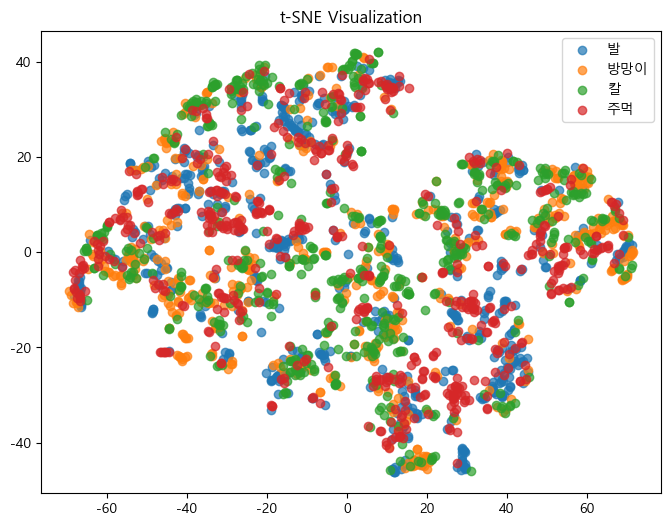

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import numpy as np

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False


X = np.stack(df["keypoints"].values)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(8,6))
for cat in categories:
    idx = df["category"] == cat
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=cat, alpha=0.7)
plt.title("t-SNE Visualization")
plt.legend()
plt.show()

### UMAP

입력 데이터:
X = np.stack(df["keypoints"].values)
→ 각 샘플(행동 영상)의 keypoints(관절 좌표) 평균값 벡터가 입력입니다. 즉, 한 영상의 대표 keypoints(좌표값들)가 한 행(row)이 됩니다.

차원 축소:
umap.UMAP(random_state=42)
→ 원래 keypoints 벡터(예: 30차원)를 2차원으로 축소하여, 데이터의 구조적 유사성을 최대한 보존하면서 시각화합니다.

색상/마커 그룹:
for cat in categories: ... plt.scatter(..., label=cat)
→ 각 카테고리(발차기, 방망이, 칼, 주먹)별로 색을 달리해서 표시합니다.

해석:

가까운 점: keypoints 패턴이 유사한(즉, 행동이 비슷한) 샘플끼리 2D 평면에서 가깝게 위치합니다.
멀리 떨어진 점: keypoints 패턴이 다른(즉, 행동이 다른) 샘플끼리는 멀리 위치합니다.
클러스터: 같은 행동 카테고리끼리 모여 있다면, 해당 행동의 keypoints 패턴이 서로 유사하다는 의미입니다.
요약:
UMAP 시각화는 각 행동(발차기, 방망이, 칼, 주먹)별 keypoints 평균값의 유사도를 2차원 공간에 투영하여, 행동별 패턴의 차이와 군집(클러스터) 구조를 한눈에 볼 수 있게 해줍니다.

c:\Users\dlals\anaconda3\envs\behavior\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dlals\anaconda3\envs\behavior\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


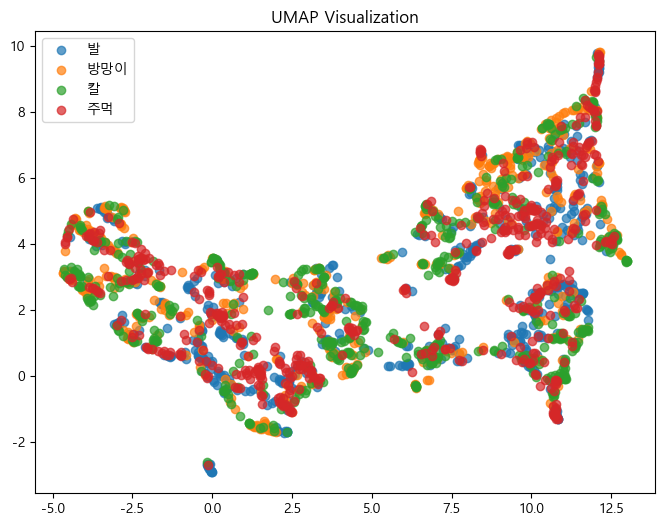

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import umap
import numpy as np

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

X = np.stack(df["keypoints"].values)
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)
plt.figure(figsize=(8,6))
for cat in categories:
    idx = df["category"] == cat
    plt.scatter(X_umap[idx,0], X_umap[idx,1], label=cat, alpha=0.7)
plt.title("UMAP Visualization")
plt.legend()
plt.show()

### 통계량 분석
#### CCA

In [24]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# X: keypoints (이미 np.stack(df["keypoints"].values)로 준비됨)
X = np.stack(df["keypoints"].values)

# Y: 행동 레이블을 one-hot 또는 label encoding (예시: 주먹, 방망이, 칼, 발차기)
le = LabelEncoder()
y_labels = le.fit_transform(df["category"])
Y = np.eye(len(le.classes_))[y_labels]  # one-hot encoding

# CCA 분석 (2개 정준변수)
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X, Y)

# 정준상관계수
corr1 = np.corrcoef(X_c[:,0], Y_c[:,0])[0,1]
corr2 = np.corrcoef(X_c[:,1], Y_c[:,1])[0,1]
print(f"정준상관계수 1: {corr1:.3f}, 2: {corr2:.3f}")

# ====== 시각화 코드 추가 ======
plt.figure(figsize=(8,6))
for i, cat in enumerate(le.classes_):
    idx = y_labels == i
    plt.scatter(X_c[idx,0], X_c[idx,1], label=cat, alpha=0.7)
plt.xlabel("1")
plt.ylabel("2")
plt.title("CCA 시각화")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'df' is not defined

정준상관계수: 0.651246346298051


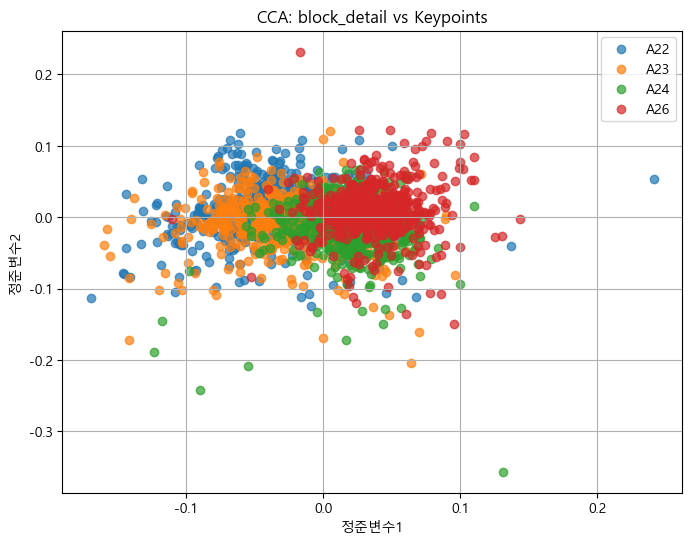

In [ ]:
# X: keypoints
X = np.stack(df["keypoints"].values)
# Y: block_detail one-hot
le2 = LabelEncoder()
block_labels = le2.fit_transform(df["block_detail"].astype(str))
Y2 = np.eye(len(le2.classes_))[block_labels]

cca2 = CCA(n_components=2)
X_c2, Y_c2 = cca2.fit_transform(X, Y2)
print("정준상관계수:", np.corrcoef(X_c2[:,0], Y_c2[:,0])[0,1])

plt.figure(figsize=(8,6))
for i, bd in enumerate(le2.classes_):
    idx = block_labels == i
    plt.scatter(X_c2[idx,0], X_c2[idx,1], label=bd, alpha=0.7)
plt.title("CCA: block_detail vs Keypoints")
plt.xlabel("정준변수1"); plt.ylabel("정준변수2")
plt.legend(); plt.grid(True); plt.show()

keypoints 평균값과 block_detail(label encoded) 상관계수: -0.042


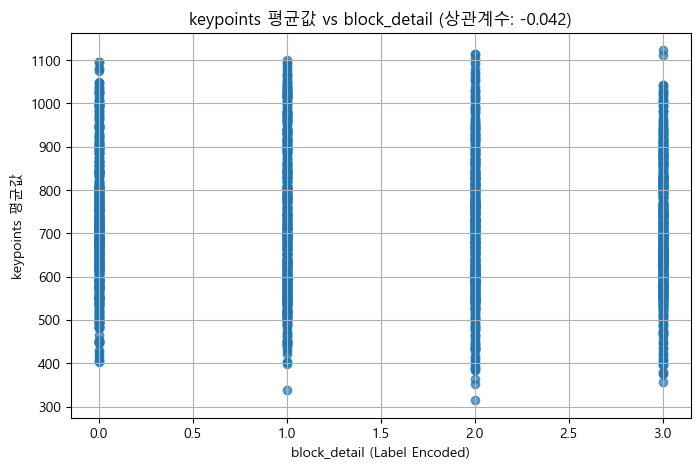

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# keypoints의 전체 평균값(벡터)
keypoints_mean = np.mean(X, axis=1)

# block_detail을 숫자형으로 변환
le = LabelEncoder()
block_detail_encoded = le.fit_transform(df["block_detail"].astype(str))

# 상관계수 계산
corr = np.corrcoef(keypoints_mean, block_detail_encoded)[0,1]
print(f"keypoints 평균값과 block_detail(label encoded) 상관계수: {corr:.3f}")

# ====== 시각화 코드 추가 ======
plt.figure(figsize=(8,5))
plt.scatter(block_detail_encoded, keypoints_mean, alpha=0.7)
plt.xlabel("block_detail (Label Encoded)")
plt.ylabel("keypoints 평균값")
plt.title(f"keypoints 평균값 vs block_detail (상관계수: {corr:.3f})")
plt.grid(True)
plt.show()

## 비디오 부분 커팅

In [26]:
import cv2
import os
import json

json_dir = r'dataset/1.Training/new_labeling_data/bat'
mp4_dir = r'dataset/1.Training/video/bat'
save_root = r'cut_videos/bat'
os.makedirs(save_root, exist_ok=True)

for json_file in os.listdir(json_dir):
    if not json_file.endswith('.json'):
        continue
    json_path = os.path.join(json_dir, json_file)
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    base_name = os.path.splitext(json_file)[0]
    mp4_name = base_name + '.mp4'
    mp4_path = os.path.join(mp4_dir, mp4_name)
    if not os.path.exists(mp4_path):
        print(f"mp4 파일 없음: {mp4_path}")
        continue

    frames = data.get("frames", [])
    if not frames:
        print(f"프레임 정보 없음: {json_file}")
        continue
    start_idx = int(frames[0]["frame_index"])
    end_idx = int(frames[-1]["frame_index"])

    cap = cv2.VideoCapture(mp4_path)
    if not cap.isOpened():
        print(f"비디오 열기 실패: {mp4_path}")
        continue

    # 비디오 정보
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    save_path = os.path.join(save_root, f"{base_name}_cut.mp4")
    out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))

    for idx in range(start_idx, end_idx + 1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"프레임 읽기 실패: {mp4_name} - {idx}")
            break
        out.write(frame)

    cap.release()
    out.release()
    print(f"{json_file} → {save_path} 저장 완료")

C031_A23_SY21_P01_S06_10DAS.json → cut_videos/bat\C031_A23_SY21_P01_S06_10DAS_cut.mp4 저장 완료
C031_A23_SY21_P01_S07_09DAS.json → cut_videos/bat\C031_A23_SY21_P01_S07_09DAS_cut.mp4 저장 완료
C031_A23_SY21_P01_S10_08DAS.json → cut_videos/bat\C031_A23_SY21_P01_S10_08DAS_cut.mp4 저장 완료
C031_A23_SY21_P01_S10_08DBS.json → cut_videos/bat\C031_A23_SY21_P01_S10_08DBS_cut.mp4 저장 완료
C031_A23_SY21_P01_S10_09DAS.json → cut_videos/bat\C031_A23_SY21_P01_S10_09DAS_cut.mp4 저장 완료
C031_A23_SY21_P01_S10_10DAS.json → cut_videos/bat\C031_A23_SY21_P01_S10_10DAS_cut.mp4 저장 완료
C031_A23_SY21_P01_S10_10DBS.json → cut_videos/bat\C031_A23_SY21_P01_S10_10DBS_cut.mp4 저장 완료


KeyboardInterrupt: 

#### 데이터 프레임 설정

In [27]:
import os
import json
import numpy as np
import pandas as pd

# json 파일들이 들어있는 폴더 경로
json_dir = r'dataset\1.Training\new_labeling_data'

categories = ['foot', 'bat', 'knif', 'fist']
data_list = []

for category in categories:
    folder = os.path.join(json_dir, category)
    for file in os.listdir(folder):
        if not file.endswith('.json'):
            continue
        with open(os.path.join(folder, file), 'r', encoding='utf-8') as f:
            data = json.load(f)
        # category
        cat = category
        # keypoints: 모든 프레임, 첫 번째 사람의 keypoints만 평균
        keypoints = []
        for frame in data.get("frames", []):
            persons = frame.get("keypoints", [])
            if persons and len(persons[0]) > 0:
                kp_arr = []
                for kp in persons[0]:
                    try:
                        x, y = map(float, kp.split(','))
                        kp_arr.extend([x, y])
                    except:
                        kp_arr.extend([0.0, 0.0])
                keypoints.append(kp_arr)
        if keypoints:
            keypoints_mean = np.mean(keypoints, axis=0)
        else:
            keypoints_mean = np.zeros(30)  # 예시: 15 keypoints x 2
        data_list.append({
            "filename": data.get("filename"),
            "category": cat,
            "keypoints": keypoints_mean
        })

df = pd.DataFrame(data_list)
print(df.head())
print("df shape:", df.shape)

                          filename category  \
0  C032_A26_SY21_P01_S01_01DAS.mp4     foot   
1  C032_A26_SY21_P01_S01_01DBS.mp4     foot   
2  C032_A26_SY21_P01_S01_02DAS.mp4     foot   
3  C032_A26_SY21_P01_B02_01DAS.mp4     foot   
4  C032_A26_SY21_P01_B02_01DBS.mp4     foot   

                                           keypoints  
0  [522.7247140739998, 254.521561272, 679.3943154...  
1  [790.4461859619998, 371.33704971600014, 780.25...  
2  [395.50962959599997, 200.352233694, 706.412684...  
3  [346.9147830240002, 211.54129810799972, 609.29...  
4  [971.9186203579999, 388.87486046199996, 999.89...  
df shape: (2344, 3)


## 머신러닝 모델
### 1. Logistic Regression

Logistic Regression 정확도: 0.5352


c:\Users\dlals\anaconda3\envs\behavior\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 600x600 with 0 Axes>

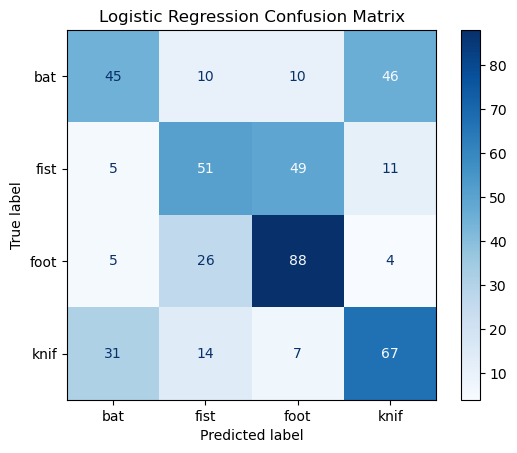

In [28]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X = np.stack(df["keypoints"].values)
y = df["category"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression 정확도: {acc_logreg:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 혼동행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred_logreg, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### 2. SVC (Support Vector Classifier)

SVC 정확도: 0.5267


<Figure size 600x600 with 0 Axes>

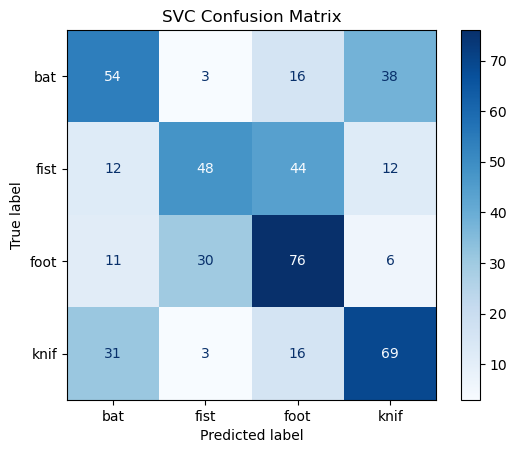

In [32]:
# 2. SVC (Support Vector Classifier)
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVC 정확도: {acc_svc:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("SVC Confusion Matrix")
plt.show()

### 3. Random Forest

Random Forest 정확도: 0.6780


<Figure size 600x600 with 0 Axes>

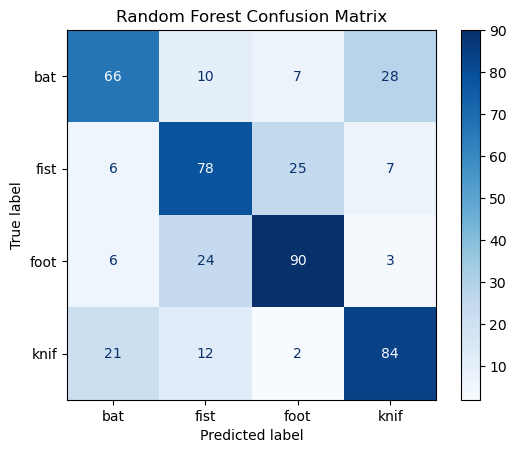

In [30]:
# 3. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest 정확도: {acc_rf:.4f}")

# ...existing code...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.show()
# ...existing code...

### 4. Gradient Boosting

Gradient Boosting 정확도: 0.6098


<Figure size 600x600 with 0 Axes>

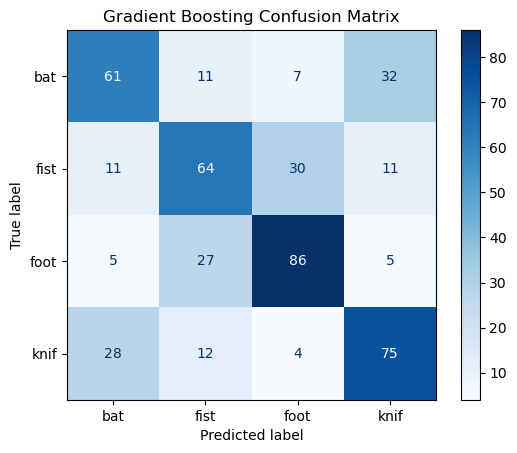

In [31]:
# 4. Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting 정확도: {acc_gb:.4f}")

# ...existing code...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_gb, labels=gb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()
# ...existing code...

### 5. K-Nearest Neighbors

KNN 정확도: 0.5672


<Figure size 600x600 with 0 Axes>

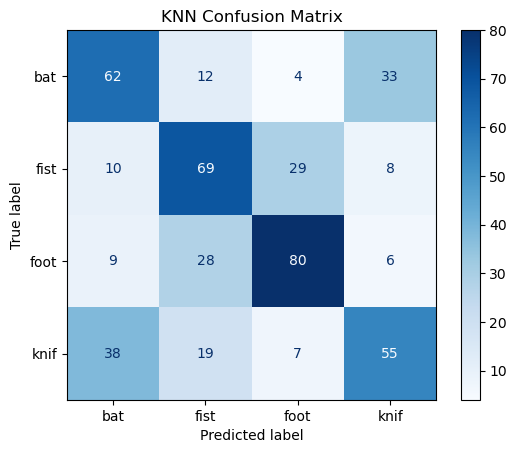

In [11]:
# 5. K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN 정확도: {acc_knn:.4f}")

# ...existing code...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("KNN Confusion Matrix")
plt.show()
# ...existing code...

## 딥러닝 모델

### 1. MLP (Multi-Layer Perceptron) 분류기

Epoch 1, Loss: 19.8459, Accuracy: 0.2841
Epoch 2, Loss: 2.5943, Accuracy: 0.3626
Epoch 3, Loss: 1.9914, Accuracy: 0.3904
Epoch 4, Loss: 1.9376, Accuracy: 0.3985
Epoch 5, Loss: 1.9009, Accuracy: 0.4027
Epoch 6, Loss: 1.6037, Accuracy: 0.4253
Epoch 7, Loss: 1.6214, Accuracy: 0.4377
Epoch 8, Loss: 1.4074, Accuracy: 0.4578
Epoch 9, Loss: 1.4356, Accuracy: 0.4492
Epoch 10, Loss: 1.3935, Accuracy: 0.4616
Epoch 11, Loss: 1.3856, Accuracy: 0.4697
Epoch 12, Loss: 1.6001, Accuracy: 0.4309
Epoch 13, Loss: 1.3217, Accuracy: 0.4876
Epoch 14, Loss: 1.2873, Accuracy: 0.4608
Epoch 15, Loss: 1.2186, Accuracy: 0.4842
Epoch 16, Loss: 1.2226, Accuracy: 0.4812
Epoch 17, Loss: 1.1702, Accuracy: 0.4970
Epoch 18, Loss: 1.1213, Accuracy: 0.4898
Epoch 19, Loss: 1.1411, Accuracy: 0.5090
Epoch 20, Loss: 1.1434, Accuracy: 0.5060
Epoch 21, Loss: 1.1435, Accuracy: 0.5030
Epoch 22, Loss: 1.1927, Accuracy: 0.4804
Epoch 23, Loss: 1.1272, Accuracy: 0.5051
Epoch 24, Loss: 1.1340, Accuracy: 0.5004
Epoch 25, Loss: 1.1295, 

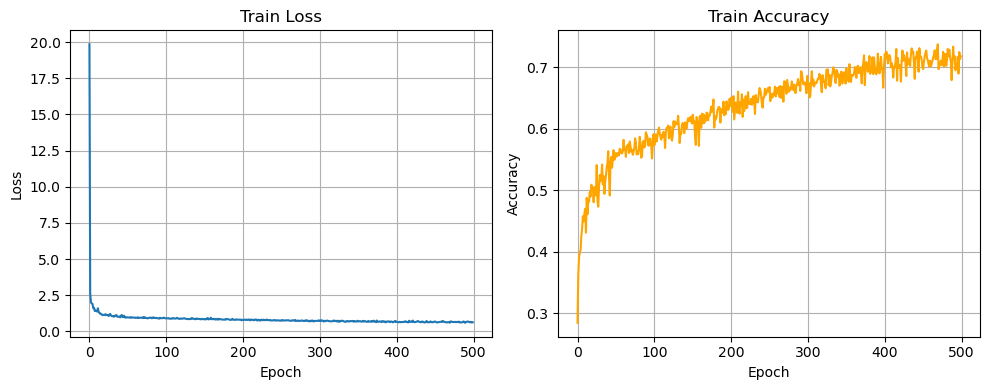

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# DataFrame에서 keypoints와 category 추출
X = np.stack(df["keypoints"].values)
y = df["category"].values

# 데이터 준비
X_tensor = torch.tensor(X, dtype=torch.float32)
le = LabelEncoder()
y_tensor = torch.tensor(le.fit_transform(y), dtype=torch.long)

# 데이터셋/로더
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# MLP 모델
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X.shape[1], num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

loss_list = []
acc_list = []

for epoch in range(500):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, pred = torch.max(out, 1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    loss_list.append(avg_loss)
    acc_list.append(acc)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

# 학습 곡선 시각화
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(acc_list, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 시각화

<Figure size 600x600 with 0 Axes>

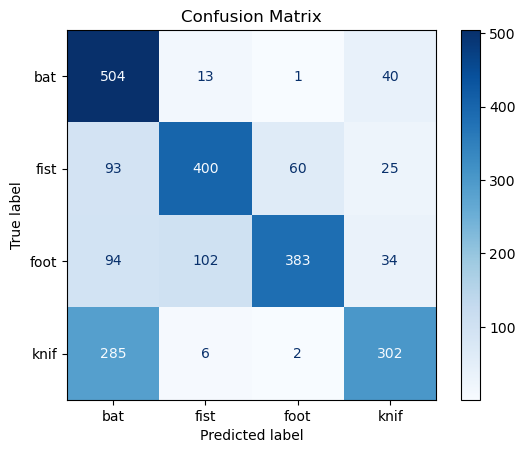

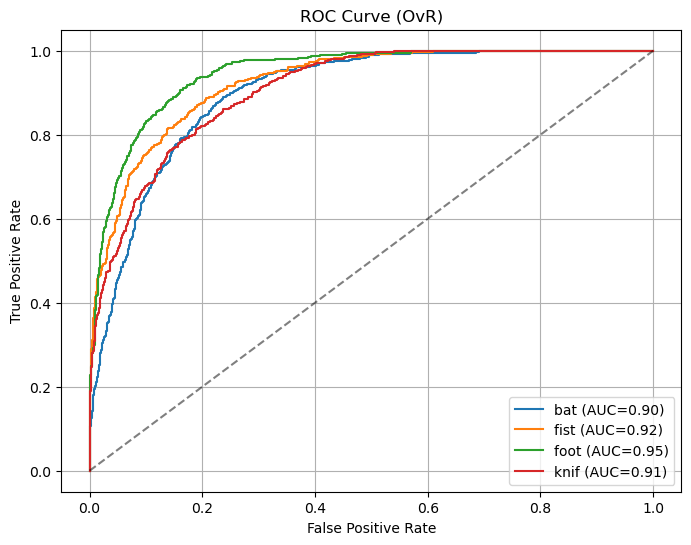

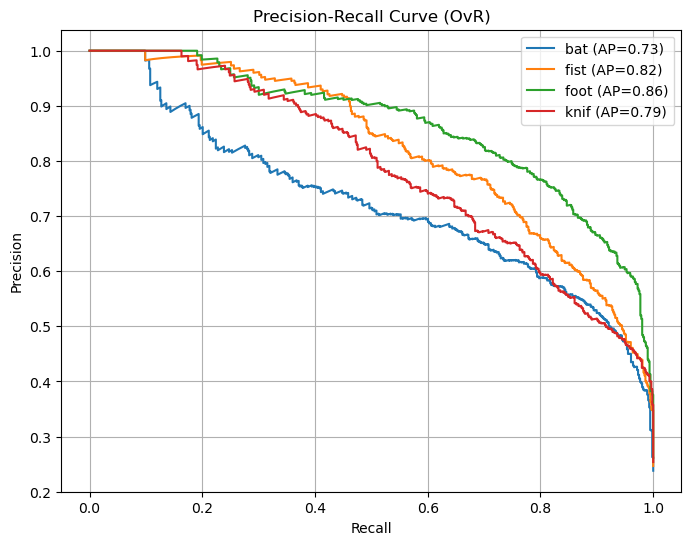

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# 모델 평가 모드
model.eval()
with torch.no_grad():
    outputs = model(X_tensor)
    probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)
    y_true = y_tensor.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve & AUC (One-vs-Rest)
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()

# PR Curve & Average Precision
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), probs[:,i])
    ap = average_precision_score((y_true == i).astype(int), probs[:,i])
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()

### 2. 1D CNN 분류기

Epoch 1, Loss: 4.8965, Accuracy: 0.2619
Epoch 2, Loss: 1.4567, Accuracy: 0.2931
Epoch 3, Loss: 1.4778, Accuracy: 0.3093
Epoch 4, Loss: 1.4665, Accuracy: 0.3221
Epoch 5, Loss: 1.3871, Accuracy: 0.3477
Epoch 6, Loss: 1.3389, Accuracy: 0.3771
Epoch 7, Loss: 1.3421, Accuracy: 0.3741
Epoch 8, Loss: 1.3220, Accuracy: 0.3925
Epoch 9, Loss: 1.3838, Accuracy: 0.3737
Epoch 10, Loss: 1.2914, Accuracy: 0.4108
Epoch 11, Loss: 1.3395, Accuracy: 0.3968
Epoch 12, Loss: 1.3653, Accuracy: 0.3989
Epoch 13, Loss: 1.3188, Accuracy: 0.4074
Epoch 14, Loss: 1.2745, Accuracy: 0.4185
Epoch 15, Loss: 1.2596, Accuracy: 0.4202
Epoch 16, Loss: 1.3146, Accuracy: 0.4087
Epoch 17, Loss: 1.2779, Accuracy: 0.4168
Epoch 18, Loss: 1.3158, Accuracy: 0.4100
Epoch 19, Loss: 1.2822, Accuracy: 0.4253
Epoch 20, Loss: 1.2888, Accuracy: 0.4288
Epoch 21, Loss: 1.2392, Accuracy: 0.4403
Epoch 22, Loss: 1.2185, Accuracy: 0.4411
Epoch 23, Loss: 1.2267, Accuracy: 0.4424
Epoch 24, Loss: 1.2551, Accuracy: 0.4373
Epoch 25, Loss: 1.2181, A

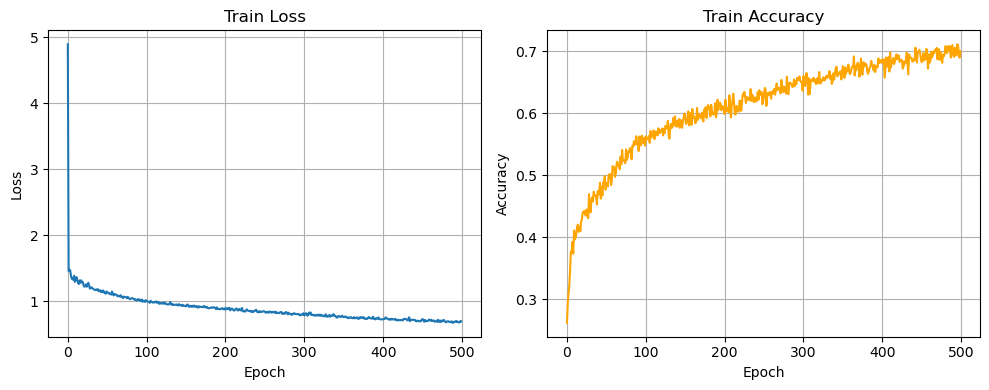

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, num_classes)
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_dim)
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)

model = CNN1D(input_dim=X.shape[1], num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

loss_list = []
acc_list = []

for epoch in range(500):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, pred = torch.max(out, 1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    loss_list.append(avg_loss)
    acc_list.append(acc)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

# 학습 곡선 시각화
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(acc_list, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 시각화

<Figure size 600x600 with 0 Axes>

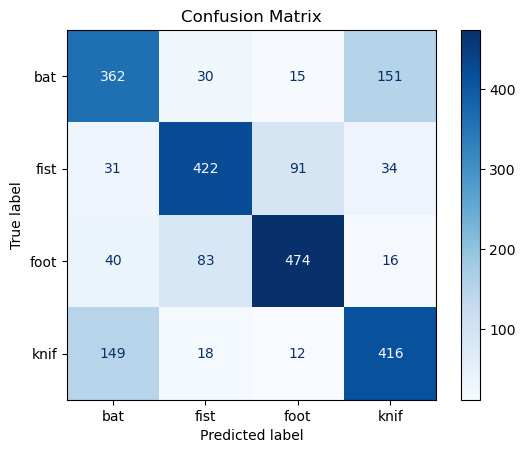

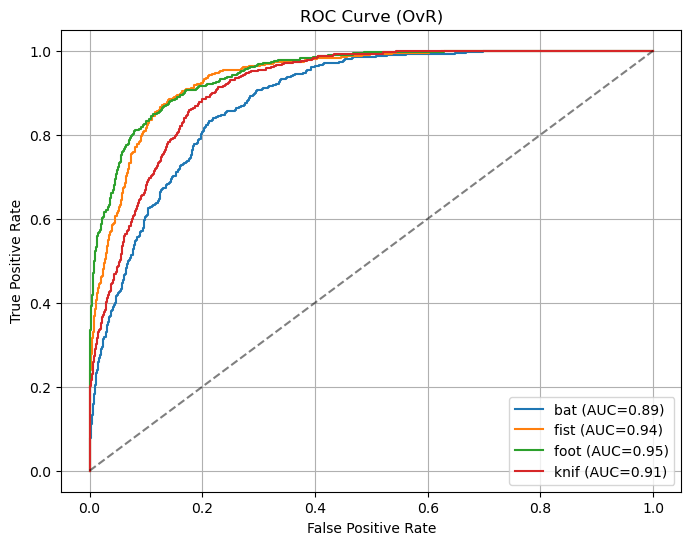

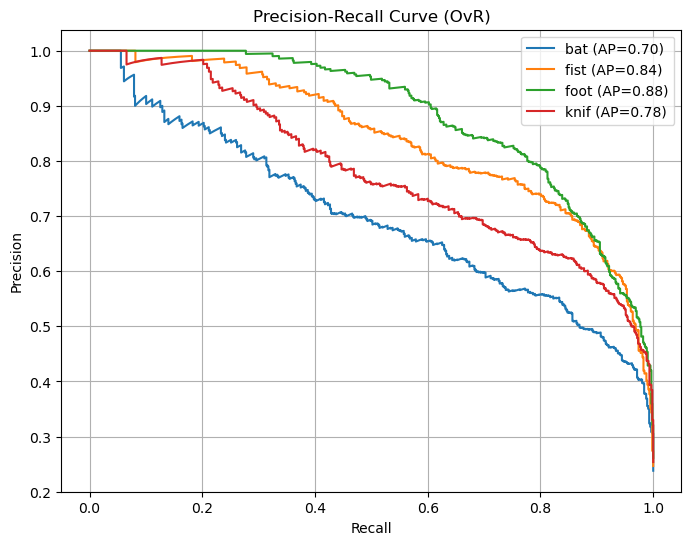

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# 모델 평가 모드
model.eval()
with torch.no_grad():
    outputs = model(X_tensor)
    probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)
    y_true = y_tensor.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve & AUC (One-vs-Rest)
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()

# PR Curve & Average Precision
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), probs[:,i])
    ap = average_precision_score((y_true == i).astype(int), probs[:,i])
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df

filename category  \
0     C032_A26_SY21_P01_S01_01DAS.mp4     foot   
1     C032_A26_SY21_P01_S01_01DBS.mp4     foot   
2     C032_A26_SY21_P01_S01_02DAS.mp4     foot   
3     C032_A26_SY21_P01_B02_01DAS.mp4     foot   
4     C032_A26_SY21_P01_B02_01DBS.mp4     foot   
...                               ...      ...   
2339  C032_A24_SY23_P03_S17_03DAS.mp4     fist   
2340  C032_A24_SY23_P03_S18_01DBS.mp4     fist   
2341  C032_A24_SY23_P03_S18_02DAS.mp4     fist   
2342  C032_A24_SY23_P03_S18_02DBS.mp4     fist   
2343  C032_A24_SY23_P03_S18_03DAS.mp4     fist   

                                              keypoints  
0     [522.7247140739998, 254.521561272, 679.3943154...  
1     [790.4461859619998, 371.33704971600014, 780.25...  
2     [395.50962959599997, 200.352233694, 706.412684...  
3     [346.9147830240002, 211.54129810799972, 609.29...  
4     [971.9186203579999, 388.87486046199996, 999.89...  
...                                                 ...  
2339  [1348.5003982459998, 239.75324967200012, 1545....  
2340  [947.1179306300003, 284.78636996200015, 885.83...  
2341  [1044.509322743999, 212.59751072000006, 1086.6...  
2342  [967.6627582659991, 300.4865504720001, 897.230...  
2343  [1120.6597330160007, 220.456075296, 1086.70989...  

[2344 rows x 3 columns]

## Odd ratio CI p-value

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# fist vs 기타 (is_fist: 1이면 fist, 0이면 기타)
df['is_fist'] = (df['category'] == 'fist').astype(int)
print("y 값 분포:", df['is_fist'].value_counts())

if df['is_fist'].nunique() < 2:
    print("y(주먹)가 0 또는 1만 존재합니다. 오즈비 계산 불가. 다른 category로 시도하세요.")
else:
    x1 = df['keypoints'].apply(lambda x: x[0])
    print("고유값 개수:", x1.nunique())
    if x1.nunique() == 1:
        X = df['keypoints'].apply(np.mean)
    else:
        X = x1
    X = sm.add_constant(X)
    y = df['is_fist']
    if y.nunique() == 2 and X.iloc[:,1].nunique() > 1:
        model = sm.Logit(y, X)
        result = model.fit(disp=0)
        # 위치 인덱싱을 iloc으로 변경
        odds_ratio = np.exp(result.params.iloc[1])
        conf = result.conf_int()
        conf_odds = np.exp(conf.iloc[1])
        p_value = result.pvalues.iloc[1]
        print(f"Odds Ratio: {odds_ratio:.3f}")
        print(f"95% CI: [{conf_odds[0]:.3f}, {conf_odds[1]:.3f}]")
        print(f"p-value: {p_value:.4f}")
    else:
        print("입력 feature 또는 y값이 상수입니다. 다른 feature를 사용하거나 데이터를 확인하세요.")

y 값 분포: is_fist
0    1766
1     578
Name: count, dtype: int64
고유값 개수: 2331
Odds Ratio: 0.999
95% CI: [0.999, 1.000]
p-value: 0.0000


## shap summary / dependency / force plot / LIME

c:\Users\dlals\anaconda3\envs\behavior\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

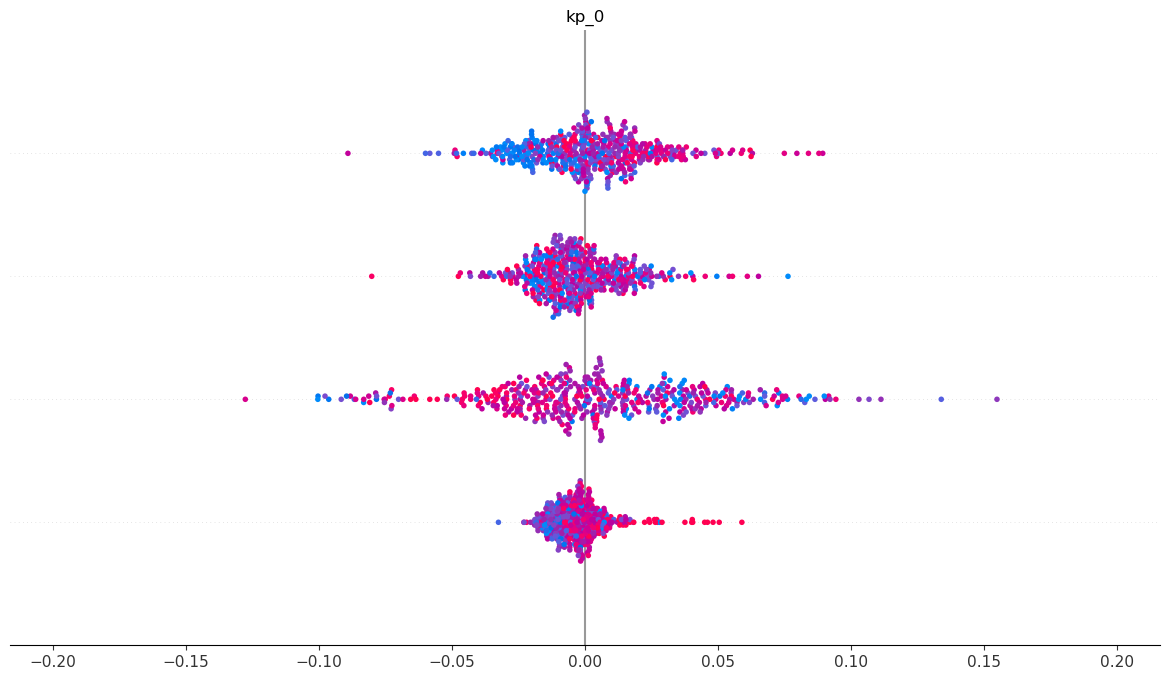

X_test.shape: (469, 30)
type(shap_values): <class 'numpy.ndarray'>
shap_values.shape: (469, 30, 4)


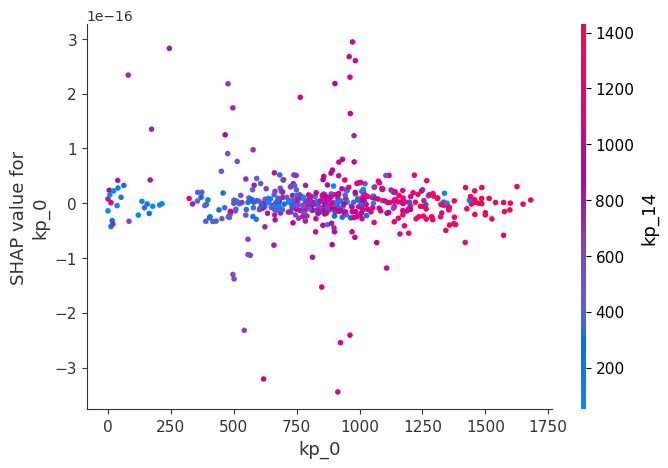

In [18]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비
X = np.stack(df["keypoints"].values)
y = df["category"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습 (Random Forest 예시)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 1. SHAP summary plot (전체 feature 영향)
shap.summary_plot(shap_values, X_test, feature_names=[f'kp_{i}' for i in range(X.shape[1])])

# 2. SHAP dependency plot (특정 feature와 타겟의 관계)
print("X_test.shape:", X_test.shape)
print("type(shap_values):", type(shap_values))
print("shap_values.shape:", getattr(shap_values, 'shape', 'no shape'))

# SHAP 값 변환: (n_samples, n_features, n_classes) → (n_samples, n_features)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[0] == X_test.shape[0]:
    sv = shap_values.mean(axis=2)  # 클래스별 SHAP 평균
elif isinstance(shap_values, np.ndarray) and shap_values.shape == X_test.shape:
    sv = shap_values
else:
    raise ValueError(f"SHAP 값의 shape가 예상과 다릅니다. shap_values.shape: {getattr(shap_values, 'shape', 'no shape')}, X_test.shape: {X_test.shape}")

assert sv.shape == X_test.shape, f"Shape mismatch: sv {sv.shape}, X_test {X_test.shape}"

shap.dependence_plot(0, sv, X_test, feature_names=[f'kp_{i}' for i in range(X.shape[1])])

# 3. SHAP force plot (개별 예측 해석)
shap.initjs()

# force plot을 위한 shap 값 준비
sample_idx = 0
class_idx = 0

sample_shap_values = shap_values[sample_idx, :, class_idx]  # (n_features,)
sample_features = X_test[sample_idx, :]                     # (n_features,)
expected_value = explainer.expected_value[class_idx]

# force plot 객체 생성
force_plot_html = shap.force_plot(
    expected_value,
    sample_shap_values,
    sample_features,
    feature_names=[f'kp_{i}' for i in range(X.shape[1])],
    matplotlib=False  # HTML 기반으로 생성
)

# HTML 저장 (파일 열어서 CSS 배경 흰색으로 수정 가능)
shap.save_html("shap_force_plot_white.html", force_plot_html)

# 4. LIME 해석 (개별 예측 설명)
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=[f'kp_{i}' for i in range(X.shape[1])],
    class_names=np.unique(y_train),
    discretize_continuous=True
)
i = 0  # 테스트 샘플 인덱스
lime_exp = lime_explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)
lime_exp.show_in_notebook(show_table=True)


## subgroup analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 데이터 준비
X = np.stack(df["keypoints"].values)
y = df["category"].values

# Subgroup Analysis: 각 category별로 분석
categories = np.unique(y)
subgroup_results = []

for category in categories:
    print(f"Subgroup: {category}")
    
    # Subgroup 데이터 필터링
    subgroup_mask = (y == category)
    X_subgroup = X[subgroup_mask]
    y_subgroup = y[subgroup_mask]
    
    # 데이터가 충분한지 확인
    if len(y_subgroup) < 10:  # 최소 샘플 수 조건
        print(f"Insufficient data for category {category}. Skipping...")
        continue
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_subgroup, y_subgroup, test_size=0.2, random_state=42, stratify=y_subgroup
    )
    
    # 모델 학습
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {category}: {acc:.4f}")
    
    subgroup_results.append({
        "category": category,
        "accuracy": acc,
        "train_size": len(y_train),
        "test_size": len(y_test)
    })

subgroup_df = pd.DataFrame(subgroup_results)
print("\nSubgroup Analysis Results:")
print(subgroup_df)

Subgroup: bat
Accuracy for bat: 1.0000
Subgroup: fist
Accuracy for fist: 1.0000
Subgroup: foot
Accuracy for foot: 1.0000
Subgroup: knif
Accuracy for knif: 1.0000

Subgroup Analysis Results:
  category  accuracy  train_size  test_size
0      bat       1.0         446        112
1     fist       1.0         462        116
2     foot       1.0         490        123
3     knif       1.0         476        119


## 미디어 파이프 활용

In [12]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [62]:
import cv2

img = cv2.imread("test_img.png")
cv2.imshow('Image Window', img)
cv2.waitKey(0)  # 키보드 입력을 기다림 (0은 무한 대기)
cv2.destroyAllWindows()  # 모든 윈도우 닫기

In [79]:
import json
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# ❌ 제외할 랜드마크 인덱스
excluded_indices = set(range(0, 11)) | {17, 18, 19, 20, 21, 22, 31, 32}

# ✅ 모델 로드
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
detector = vision.PoseLandmarker.create_from_options(options)

# ✅ 이미지 로드 및 추론
image = mp.Image.create_from_file("test_img.png")
detection_result = detector.detect(image)

# ✅ 좌표값만 추출 (선 ❌, 시각화 ❌)
pose_data = []
for landmarks in detection_result.pose_landmarks:
    filtered_pose = []
    for idx, lm in enumerate(landmarks):
        if idx not in excluded_indices:
            filtered_pose.append({
                "index": idx,
                "x": lm.x,
                "y": lm.y,
                "z": lm.z,
                "visibility": lm.visibility
            })
    pose_data.append(filtered_pose)

# ✅ JSON 저장
with open("filtered_pose_coordinates.json", "w", encoding="utf-8") as f:
    json.dump({"pose_landmarks": pose_data}, f, indent=4)


In [20]:
# 전체 keypoints 프린트
for frame in data["frames"]:
    print(f"Frame {frame['frame_index']}:")
    for person in frame["keypoints"]:
        for point in person:
            print(point)

Frame 2007:
949.719513,372.831086
967.331086,430.190064
927.709870,419.921494
883.585449,470.010681
845.210886,507.587865
1001.252930,434.597122
1004.137878,511.161210
999.838989,583.268158
951.253540,570.024536
927.655640,568.495941
927.610108,653.941772
930.458588,734.815033
974.833985,572.930938
971.752533,667.022400
974.631134,742.350250
755.341369,383.025970
706.862610,418.520920
740.630737,425.763580
777.512360,487.665161
820.603725,527.689870
675.908844,415.503983
665.671752,486.196976
656.959058,553.146887
701.027252,574.374451
720.052826,575.880646
743.660980,673.050019
692.112000,771.599671
687.723175,572.919190
727.510559,658.325775
717.186157,743.708527
Frame 2010:
945.211487,371.428253
959.971863,430.192993
927.465149,424.281830
883.469421,480.187164
847.328633,509.888419
1001.083252,433.174561
1007.067444,506.895203
1018.801208,577.295349
951.227173,565.630005
927.592773,562.660339
927.537598,653.946716
927.709167,736.231445
974.837097,568.583252
971.672668,662.733521
974

# 후기

이렇게 직접 데이터 프레임을 만들고 모델별 비교를 돌려본 것은 처음 이었습니다. 항상 특정 모델을 가져와서 서비스를 만들고 어떻게 배포할지만 생각해보았지 어떤 모델이 가장 좋은지는 생각해본적 없던 것 같습니다. 이번 실습을 통해 많은 모델들을 조사해보며 각각 어떤 이점이 있는지, 데이터를 구상하면서 어떤 모델을 사용해야 좋은지 생각해보는 시간이 된 것 같습니다.